In [1]:
import pandas as pd
import sklearn as sk
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
%load_ext autoreload
%autoreload 2

# Load data

In [4]:
import re


HTTP_RE = re.compile(r"ST@RT.+?INFO\s+(.+?)\s+END", re.MULTILINE | re.DOTALL)
    
    
def get_dataset(filename):
    with open(filename, 'r') as f:
        all_requests = HTTP_RE.findall(f.read())
    
    return pd.DataFrame({'request': all_requests})
    
    
    
train_df = get_dataset('data/vulnbank_train.txt')
train_df

,request
0,GET /vulnbank/index.html HTTP/1.1\nHost: 10.0....
1,GET /vulnbank/index.html HTTP/1.1\nHost: 10.0....
2,GET /vulnbank/online/login.php HTTP/1.1\nHost:...
3,GET / HTTP/1.1\nHost: 10.0.212.25\nConnection:...
4,GET /vulnbank/index.html HTTP/1.1\nHost: 10.0....
...,...
21986,GET /vulnbank/online/logout.php HTTP/1.1\nAcce...
21987,GET /vulnbank/online/logout.php HTTP/1.1\nAcce...
21988,GET /vulnbank/online/logout.php HTTP/1.1\nAcce...
21989,GET /vulnbank/online/logout.php HTTP/1.1\nAcce...


In [5]:
anomaly_df = get_dataset('data/vulnbank_anomaly.txt')
anomaly_df

,request
0,POST /vulnbank/online/api.php HTTP/1.1\nHost: ...
1,POST /vulnbank/online/api.php HTTP/1.1\nHost: ...
2,POST /vulnbank/online/api.php HTTP/1.1\nHost: ...
3,POST /vulnbank/onlinebank/api.php?xml HTTP/1.1...
4,POST /vulnbank/online/api.php HTTP/1.1\nHost: ...
...,...
1092,POST /vulnbank/online/api.php HTTP/1.1\nHost: ...
1093,POST /vulnbank/online/api.php HTTP/1.1\nHost: ...
1094,POST /vulnbank/online/ftcrats7kdsrglb4tdg1hn03...
1095,POST /vulnbank/online/'%22%3e%3csvg/onload%3d(...


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(train_df, test_size=0.1, random_state=42)
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)
    

len(X_train), len(X_test), len(X_val)

(15832, 2200, 3959)

In [7]:
X_train

,request
10137,POST /vulnbank/online/api.php HTTP/1.1\nHost: ...
18739,GET /vulnbank/online/history.php HTTP/1.1\nAcc...
4589,POST /vulnbank/online/api.php HTTP/1.1\nHost: ...
2782,POST /vulnbank/online/api.php HTTP/1.1\nHost: ...
18837,GET /vulnbank/online/history.php HTTP/1.1\nAcc...
...,...
8593,POST /vulnbank/online/api.php HTTP/1.1\nHost: ...
21046,GET /vulnbank/online/userinfo.php HTTP/1.1\nAc...
5805,POST /vulnbank/online/api.php HTTP/1.1\nHost: ...
19680,GET /vulnbank/online/transactions.php HTTP/1.0...


In [8]:
X_test

,request
21120,GET /vulnbank/online/userinfo.php HTTP/1.1\nAc...
4291,POST /vulnbank/online/api.php HTTP/1.1\nHost: ...
17978,GET /vulnbank/online/userinfo.php HTTP/1.1\nAc...
17877,GET /vulnbank/online/portal.php HTTP/1.1\nAcce...
16134,POST /vulnbank/online/api.php HTTP/1.1\nHost: ...
...,...
18062,GET /vulnbank/online/logout.php HTTP/1.1\nAcce...
8091,POST /vulnbank/online/api.php HTTP/1.1\nHost: ...
17647,GET /vulnbank/online/history.php HTTP/1.1\nAcc...
7816,POST /vulnbank/online/api.php HTTP/1.1\nHost: ...


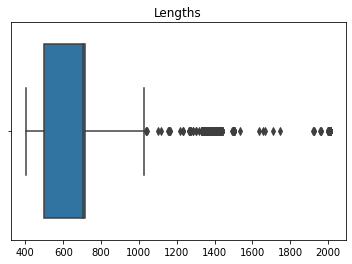

In [9]:
sns.boxplot(x=list(map(len, X_train.request))).set_title('Lengths')

plt.show()

# Prepare data

Exclude the requests with $length > 1500$ from the train set

In [10]:
print(
    'Ratio of the sample with length > 1500:',
    sum([x > 1500 for x in map(len, X_train.request)]) / len(X_train)
)

Ratio of the sample with length > 1500: 0.03922435573521981


In [11]:
X_train = X_train[[x <= 1500 for x in map(len, X_train.request)]]
X_train

,request
10137,POST /vulnbank/online/api.php HTTP/1.1\nHost: ...
18739,GET /vulnbank/online/history.php HTTP/1.1\nAcc...
2782,POST /vulnbank/online/api.php HTTP/1.1\nHost: ...
18837,GET /vulnbank/online/history.php HTTP/1.1\nAcc...
16912,GET /vulnbank/online/history.php HTTP/1.1\nAcc...
...,...
8593,POST /vulnbank/online/api.php HTTP/1.1\nHost: ...
21046,GET /vulnbank/online/userinfo.php HTTP/1.1\nAc...
5805,POST /vulnbank/online/api.php HTTP/1.1\nHost: ...
19680,GET /vulnbank/online/transactions.php HTTP/1.0...


In [12]:
from nltk import ngrams
import torchtext

from typing import Iterable


SOS = '<sos>'
EOS = '<eos>'
UNK = '<unk>'
PAD = '<pad>'

NGRAMS_PARAM = 1


def tokenize(texts: Iterable[str]):
    for text in texts:
        yield [''.join(x) for x in ngrams(text, NGRAMS_PARAM)]

vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenize(x for x in X_train.request), 
    specials=[SOS, EOS, UNK, PAD],
    min_freq=1,
)
vocab.vocab.set_default_index(vocab[UNK])

In [13]:
print(f"Unique tokens in vocabulary: {len(vocab.vocab)}")

Unique tokens in vocabulary: 87


In [14]:
from torchtext.data import to_map_style_dataset


def tokenize_dataset(df):
    for text in df.request:
        tokenized = next(tokenize([text]))

        yield {
            'text': text,
            'tokens': [vocab[SOS]] + vocab.lookup_indices(tokenized) + [vocab[EOS]],
        }


train_token_dataset = to_map_style_dataset(tokenize_dataset(X_train))
test_token_dataset = to_map_style_dataset(tokenize_dataset(X_test))
val_token_dataset = to_map_style_dataset(tokenize_dataset(X_val))

In [15]:
from torch.utils.data import DataLoader


def make_batch(batch):
    tokens = [x['tokens'] for x in batch]
    return torchtext.functional.to_tensor(tokens, padding_value=vocab[PAD]).transpose(1, 0).to(device)


BATCH_SIZE = 128


train_iterator = DataLoader(train_token_dataset, batch_size=BATCH_SIZE, collate_fn=make_batch, shuffle=True)
test_iterator = DataLoader(test_token_dataset, batch_size=BATCH_SIZE, collate_fn=make_batch)
val_iterator = DataLoader(val_token_dataset, batch_size=BATCH_SIZE, collate_fn=make_batch)

In [16]:
for x in train_iterator:
    print(x.shape)
    break

torch.Size([1425, 128])


# Set up model

In [17]:
from rnn_lstm import Encoder, Decoder, Seq2Seq, model_init


VOCAB_DIM = len(vocab.vocab)
ENC_EMB_DIM = 64
DEC_EMB_DIM = 64
ENC_HID_DIM = 64
DEC_HID_DIM = 64
NUM_LAYERS = 2
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

encoder = Encoder(VOCAB_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, NUM_LAYERS, ENC_DROPOUT)
decoder = Decoder(VOCAB_DIM, DEC_EMB_DIM, DEC_HID_DIM, NUM_LAYERS, DEC_DROPOUT)

model = Seq2Seq(encoder, decoder, device).to(device)
model = model.apply(model_init)

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 386,135 trainable parameters


In [19]:
# Check the model

model.forward(x, teacher_forcing_ratio=1.0).shape

torch.Size([1425, 128, 87])

# Train model

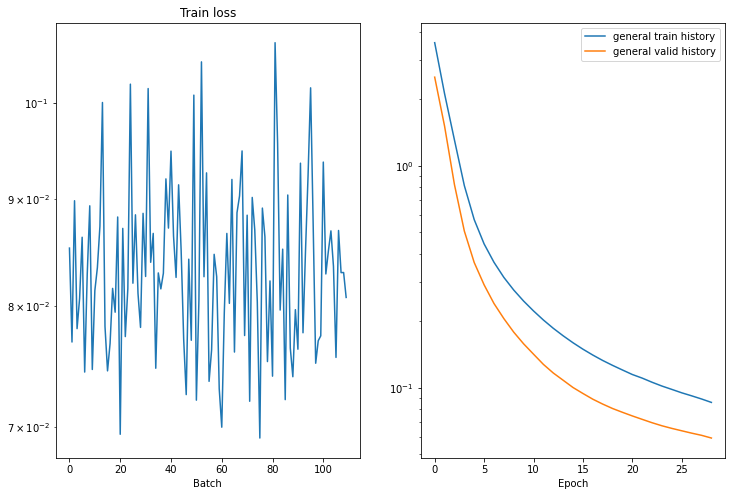

119it [03:31,  1.77s/it]


Evaluate


31it [00:18,  1.70it/s]

Epoch: 30 | Time: 3m 49s
	Train Loss: 0.084
	 Val. Loss: 0.058
Training time: 114m 31s
CPU times: user 1h 45min 59s, sys: 8min 31s, total: 1h 54min 30s
Wall time: 1h 54min 31s


In [20]:
%%time


import utils


optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss(ignore_index=vocab[PAD])
EPOCHS = 30


utils.run_training(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    epochs=EPOCHS,
    train_iterator=train_iterator,
    val_iterator=val_iterator,
    teacher_forcing_ratio=1.0
)


## Save model

In [ ]:
# torch.save(model.state_dict(), f'train_final_model.pt')

# Evaluate quality

## Load model

In [ ]:
model.load_state_dict(torch.load('model.pt', map_location=device))

## Run evaluation

In [21]:
anomaly_token_dataset = to_map_style_dataset(tokenize_dataset(anomaly_df))
anomaly_iterator = DataLoader(anomaly_token_dataset, batch_size=BATCH_SIZE, collate_fn=make_batch)

In [22]:
import tqdm


def calc_loss(loss_tensor, target):
    # loss_tensor = [batch size, request len]
    # target = [batch size, request len]
        
    loss_by_example = []
    
    for i in range(target.shape[0]):
        seq_list = target[i].tolist()
        
        padd_ix = len(seq_list)

        if vocab[PAD] in seq_list:
            padd_ix = seq_list.index(vocab[PAD])

        loss_by_example.append(
            np.mean(loss_tensor[i, :padd_ix].detach().cpu().numpy())
        )
    
    return loss_by_example


def get_loss(data_iterator):
    model.eval()
    total_loss = []

    with torch.no_grad():
        for _, batch in tqdm.tqdm(enumerate(data_iterator)):
            # batch = [request len, batch size]
            
            output = model.forward(batch, teacher_forcing_ratio=1.0)
            # output = [request len, batch size, output dim]

            output = output[1:].permute(1, 2, 0)
            target = batch[1:].permute(1, 0)

            # target = [batch size, request len]
            # output = [batch size, output dim, request len]

            loss = torch.nn.CrossEntropyLoss(ignore_index=vocab[PAD], reduction='none')(output, target)
            # loss = [batch size, request len]
            
            total_loss.extend(calc_loss(loss, target))
            

    return total_loss

In [23]:
val_losses = get_loss(val_iterator)

31it [00:18,  1.71it/s]


In [24]:
threshold = np.mean(val_losses) + 6 * np.std(val_losses)

print(f'Threshold: {threshold}')
print(f'Mean val loss: {np.mean(val_losses)}')
print(f'Std val loss: {np.std(val_losses)}')

Threshold: 0.6621706411242485
Mean val loss: 0.06590162962675095
Std val loss: 0.09937816858291626


In [25]:
test_losses = get_loss(test_iterator)
anomaly_losses = get_loss(anomaly_iterator)

18it [00:10,  1.67it/s]
9it [00:02,  3.17it/s]


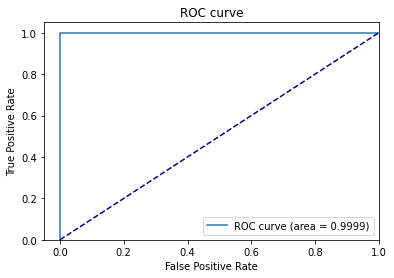

In [26]:
from sklearn.metrics import roc_curve, auc

y_true = [0 for _ in test_losses] + [1 for _ in anomaly_losses]
loss_pred = test_losses + anomaly_losses


fpr, tpr, _ = roc_curve(y_true, loss_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [27]:
roc_auc

0.9999092566503687